<font color = blue><font size = 6> 실험설명 </font></font><br>
이미 이전에 1step에서 RNN기반이 1step의 예측에 대해서 좋지 않다는 것을 몸소 경험했다 하지만 Online-learning에서는 좀 다른 결과가 나올까 기대감에 진행해 보았다<br>
<font color = blue>Online-Learning 즉, 정답 값이 들어올 때 훈련을 하고 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':8,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/online_learning_seq2seq']

In [5]:
class Encoder(nn.Module):
    def __init__(self,configs):
        super(Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden


In [6]:
class Decoder(nn.Module):
    def __init__(self,configs):
        super(Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        output = self.linear(lstm_out)
        
        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [7]:
tup= (1,2)
len(tup)

2

In [8]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.encoder = Encoder(configs)
        self.decoder = Decoder(configs)
        
    def forward(self,x):
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        _,final_hidden = self.encoder(x)
        output,_ = self.decoder(x = x[:,-1,:].view(-1,1,1),encoder_hidden = final_hidden)
        
        return output

In [5]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [10]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_500418/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [11]:
x_seq

tensor([[[0.2202, 0.2216, 0.2057,  ..., 0.2027, 0.1702, 0.1716]],

        [[0.2216, 0.2057, 0.1852,  ..., 0.1702, 0.1716, 0.2092]],

        [[0.2057, 0.1852, 0.1735,  ..., 0.1716, 0.2092, 0.2202]],

        ...,

        [[0.1641, 0.1660, 0.1776,  ..., 0.1784, 0.1696, 0.1720]],

        [[0.1660, 0.1776, 0.2252,  ..., 0.1696, 0.1720, 0.1768]],

        [[0.1776, 0.2252, 0.2034,  ..., 0.1720, 0.1768, 0.1615]]],
       device='cuda:0')

In [12]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),6*1e-6)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [13]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
        
        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
#    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

smape 199.9999999721148 %
smape 199.99999993028698 %
smape 199.99999966537743 %
smape 199.99999850814106 %
smape 199.9999964585778 %
smape 199.9999933493765 %
smape 199.99998952910215 %
smape 199.99998370109248 %
smape 199.99604021596627 %
smape 152.3568440041347 %
smape 109.77121735176844 %
smape 84.30871741813526 %
smape 63.99043995385979 %
smape 46.416282983202684 %
smape 31.074559319960443 %
smape 20.151196344379795 %
smape 15.977278465503138 %
smape 15.30173715443639 %
smape 15.263570997188664 %
smape 15.260027216540442 %
smape 15.250491286840356 %
smape 15.238366016344717 %
smape 15.22537447730003 %
smape 15.212624762316196 %
smape 15.199880924576906 %
smape 15.186854695454677 %
smape 15.174197524088864 %
smape 15.161421356058261 %
smape 15.149030749037948 %
smape 15.136500070666708 %
smape 15.124216217830863 %
smape 15.111934937406005 %
smape 15.099534967053705 %
smape 15.086872832555521 %
smape 15.074484766139621 %
smape 15.062122318828314 %
smape 15.049700259029516 %
smape 15.

In [14]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.015387307028788655 %
SMAPE 20.10379582643509 %
SMAPE 4.231125310063362 %
SMAPE 2.0890522208064795 %
SMAPE 1.293236829340458 %
SMAPE 0.40170566600477287 %
SMAPE 9.364434733986855 %
SMAPE 0.2169184076647639 %
SMAPE 0.01005290176061635 %
SMAPE 4.007633525878191 %
SMAPE 0.10807860662907844 %
SMAPE 14.28123565018177 %
SMAPE 0.05131593398039058 %
SMAPE 5.217135678976774 %
SMAPE 8.26366551965475 %
SMAPE 4.551567364484072 %
SMAPE 12.968451522290705 %
SMAPE 11.323153167963028 %
SMAPE 4.830611675977707 %
SMAPE 1.348995313514024 %
SMAPE 5.852100271731615 %
SMAPE 15.84012371301651 %
SMAPE 1.6744363717734814 %
SMAPE 1.611851650290191 %
SMAPE 1.780542547814548 %
SMAPE 7.662050411105156 %
SMAPE 9.401344768702984 %
SMAPE 0.3356236116405853 %
SMAPE 0.6484611031191889 %
SMAPE 2.9572882782667875 %
SMAPE 0.9859330989856971 %
SMAPE 22.320669293403625 %
SMAPE 4.114169519394636 %
SMAPE 1.3875871456693858 %
SMAPE 2.7909262273460627 %
SMAPE 4.8725788705050945 %
SMAPE 11.21366760879755 %
SMAPE 4.2492432

SMAPE 8.523062117397785 %
SMAPE 2.234337879344821 %
SMAPE 4.892319653183222 %
SMAPE 0.022177718798275237 %
SMAPE 15.167163893580437 %
SMAPE 2.6481474358588457 %
SMAPE 3.0439583864063025 %
SMAPE 14.772190198302267 %
SMAPE 1.6822232231497765 %
SMAPE 14.81318362057209 %
SMAPE 0.20438513266162772 %
SMAPE 0.07856182032560355 %
SMAPE 3.6407259777188306 %
SMAPE 2.359267613850534 %
SMAPE 16.35819861292839 %
SMAPE 4.4436475448310375 %
SMAPE 0.24825920426729906 %
SMAPE 7.065790694206953 %
SMAPE 4.366589076817036 %
SMAPE 10.794706389307976 %
SMAPE 0.8412808520547513 %
SMAPE 9.973896779119968 %
SMAPE 8.008618876338005 %
SMAPE 3.527305843308568 %
SMAPE 25.303342536091805 %
SMAPE 9.40698654949665 %
SMAPE 1.1871259135659784 %
SMAPE 4.151670578867197 %
SMAPE 1.2333627734333277 %
SMAPE 10.528322108089924 %
SMAPE 1.2398417491931468 %
SMAPE 1.2879130418878049 %
SMAPE 2.649658540263772 %
SMAPE 0.04983633077745253 %
SMAPE 17.607921198010445 %
SMAPE 3.0365092884749174 %
SMAPE 3.0567064117640257 %
SMAPE 7.57

SMAPE 12.979635082185267 %
SMAPE 1.306876151356846 %
SMAPE 2.7378641441464424 %
SMAPE 4.6269246600568295 %
SMAPE 5.481097459793091 %
SMAPE 2.2351637026295066 %
SMAPE 12.794473387300966 %
SMAPE 1.8290839157998562 %
SMAPE 3.5801781788468356 %
SMAPE 0.1559064759130706 %
SMAPE 16.89427198469639 %
SMAPE 5.0097564570605755 %
SMAPE 6.495035048574209 %
SMAPE 4.284517023712397 %
SMAPE 0.04154749244617051 %
SMAPE 4.755367916077375 %
SMAPE 20.261760786175728 %
SMAPE 9.947121091187 %
SMAPE 0.31601326140167885 %
SMAPE 4.825963743031025 %
SMAPE 15.580759644508364 %
SMAPE 6.33749270439148 %
SMAPE 0.0333117214122467 %
SMAPE 2.071810696274042 %
SMAPE 5.898218784481287 %
SMAPE 4.900846261531115 %
SMAPE 8.118980392813683 %
SMAPE 3.5436941869556904 %
SMAPE 4.50941551476717 %
SMAPE 3.0440875347703695 %
SMAPE 13.12789211422205 %
SMAPE 10.485853478312492 %
SMAPE 3.4141075536608696 %
SMAPE 1.9353253208100794 %
SMAPE 3.6698627341538668 %
SMAPE 0.9050549135008624 %
SMAPE 13.008918300271032 %
SMAPE 11.0650545358

SMAPE 1.6774607314728198 %
SMAPE 1.5743550737388434 %
SMAPE 12.697899349033834 %
SMAPE 7.148600343614817 %
SMAPE 0.26453226396279206 %
SMAPE 1.9589914018288257 %
SMAPE 1.247681927634403 %
SMAPE 0.05612077581065478 %
SMAPE 15.738582849502563 %
SMAPE 6.509257461875677 %
SMAPE 0.26400734752678545 %
SMAPE 5.690959520637989 %
SMAPE 13.576874211430551 %
SMAPE 9.696584843099117 %
SMAPE 3.7658213302493095 %
SMAPE 3.410515408962965 %
SMAPE 2.8831818234175444 %
SMAPE 0.7865260126454814 %
SMAPE 10.884219273924828 %
SMAPE 1.2543634176254272 %
SMAPE 2.0776781598106027 %
SMAPE 2.893436159938574 %
SMAPE 9.053380072116852 %
SMAPE 6.680128611624241 %
SMAPE 2.2597612477838993 %
SMAPE 0.5789940952154211 %
SMAPE 3.56017984636128 %
SMAPE 0.8966312508700867 %
SMAPE 15.737672984600067 %
SMAPE 9.080698609352112 %
SMAPE 4.770272061228752 %
SMAPE 0.5543583523503912 %
SMAPE 15.39321431517601 %
SMAPE 5.86703996732831 %
SMAPE 7.917002074420452 %
SMAPE 2.249575928784907 %
SMAPE 6.122971594333649 %
SMAPE 2.848358092

SMAPE 16.33104619383812 %
SMAPE 3.3735443837940693 %
SMAPE 0.407896105925829 %
SMAPE 6.2540793754160395 %
SMAPE 9.159458622336388 %
SMAPE 5.336648866534233 %
SMAPE 2.554637676104903 %
SMAPE 0.18625776127942117 %
SMAPE 3.1736204903572798 %
SMAPE 3.8550374116748576 %
SMAPE 11.027351833879948 %
SMAPE 0.7299551082833204 %
SMAPE 0.02762274313568014 %
SMAPE 4.162261489778757 %
SMAPE 16.609510138630867 %
SMAPE 9.931427709758282 %
SMAPE 0.43443856449948726 %
SMAPE 0.01971586228569322 %
SMAPE 0.5361249725579 %
SMAPE 3.321812896057964 %
SMAPE 12.028286024928093 %
SMAPE 3.307343332096934 %
SMAPE 0.13333653316044547 %
SMAPE 1.1777973915450275 %
SMAPE 13.189460828900337 %
SMAPE 6.367583762854339 %
SMAPE 1.506366598419845 %
SMAPE 3.207170968875289 %
SMAPE 0.22781701057439815 %
SMAPE 2.2445667712017894 %
SMAPE 22.088697254657745 %
SMAPE 9.818810664117336 %
SMAPE 4.048889704048634 %
SMAPE 1.1009324379265308 %
SMAPE 15.0541483014822 %
SMAPE 7.481282010674477 %
SMAPE 1.0167590416967869 %
SMAPE 1.7016738

SMAPE 0.057706267012093804 %
SMAPE 6.829472664743662 %
SMAPE 13.663318559527395 %
SMAPE 0.8941681103069641 %
SMAPE 3.890384992584586 %
SMAPE 6.951943788677455 %
SMAPE 9.938995569944382 %
SMAPE 7.435186333954334 %
SMAPE 1.7909740628674626 %
SMAPE 0.012103112547038108 %
SMAPE 0.14245295181217443 %
SMAPE 0.9189611630390573 %
SMAPE 11.700668960809708 %
SMAPE 0.8260758049946162 %
SMAPE 4.895346987992525 %
SMAPE 5.856015108525753 %
SMAPE 9.733666568994522 %
SMAPE 7.2359336912632 %
SMAPE 3.905152229592204 %
SMAPE 1.7228410164825618 %
SMAPE 0.8949080529782805 %
SMAPE 0.7320226665324299 %
SMAPE 27.674325823783875 %
SMAPE 12.246596246957779 %
SMAPE 0.07921252035138338 %
SMAPE 3.6442464105784897 %
SMAPE 7.818079672753811 %
SMAPE 12.141356699168682 %
SMAPE 0.45302159468337777 %
SMAPE 0.7010192180532613 %
SMAPE 0.14145740349682967 %
SMAPE 0.02737975145532801 %
SMAPE 14.7787474244833 %
SMAPE 6.673145402222872 %
SMAPE 1.9457739191129804 %
SMAPE 14.388634949922563 %
SMAPE 3.7380310464650393 %
SMAPE 19

SMAPE 5.634864404797554 %
SMAPE 2.972596015781164 %
SMAPE 1.0720939104230638 %
SMAPE 8.6626006513834 %
SMAPE 14.326120868325235 %
SMAPE 4.5789432637393475 %
SMAPE 2.5088501581922174 %
SMAPE 0.15066876471144042 %
SMAPE 8.45520842820406 %
SMAPE 8.976373687386513 %
SMAPE 0.1665980251293604 %
SMAPE 2.0675194580107927 %
SMAPE 2.609708620235324 %
SMAPE 0.020567862346666743 %
SMAPE 33.22741836309433 %
SMAPE 19.644406020641327 %
SMAPE 14.793732017278671 %
SMAPE 0.7308292867965065 %
SMAPE 13.411284931004047 %
SMAPE 3.397194804623723 %
SMAPE 9.207926638424397 %
SMAPE 1.0785319535061717 %
SMAPE 2.66286364197731 %
SMAPE 1.6864580218680203 %
SMAPE 19.953133270144463 %
SMAPE 11.307424612343311 %
SMAPE 4.622297670692205 %
SMAPE 9.5795284435153 %
SMAPE 8.475918181240559 %
SMAPE 4.153984356671572 %
SMAPE 1.8972138427197933 %
SMAPE 3.7461135294288397 %
SMAPE 0.3982478700846741 %
SMAPE 1.6177404071204364 %
SMAPE 16.479039132595062 %
SMAPE 11.690598577260971 %
SMAPE 0.5537253928614518 %
SMAPE 3.6035940553

SMAPE 0.18337744674892065 %
SMAPE 5.016044776886702 %
SMAPE 3.4559736866503954 %
SMAPE 0.03639936073075489 %
SMAPE 1.2522793661337346 %
SMAPE 17.62422114610672 %
SMAPE 13.833666384220123 %
SMAPE 8.001046538352966 %
SMAPE 1.342884705401957 %
SMAPE 7.664786361157894 %
SMAPE 2.7044539097696543 %
SMAPE 5.081380542367697 %
SMAPE 0.03835460944128499 %
SMAPE 1.0958085544407368 %
SMAPE 0.30510883751981055 %
SMAPE 18.14994642138481 %
SMAPE 9.716584257781506 %
SMAPE 0.16946033813535166 %
SMAPE 7.50999791175127 %
SMAPE 6.743510100990534 %
SMAPE 4.799121081829071 %
SMAPE 1.1972679322352633 %
SMAPE 0.5972922531530003 %
SMAPE 7.331363417208195 %
SMAPE 1.5959255448542535 %
SMAPE 15.832176148891449 %
SMAPE 4.149542421102524 %
SMAPE 0.655040772704524 %
SMAPE 0.3730334177025725 %
SMAPE 7.461300700902938 %
SMAPE 7.396786607801914 %
SMAPE 3.042798662558198 %
SMAPE 0.7232631969000067 %
SMAPE 0.9076363621279597 %
SMAPE 0.29683738343510413 %
SMAPE 22.66850981116295 %
SMAPE 7.472818158566952 %
SMAPE 0.6862176

SMAPE 1.9334734342992308 %
SMAPE 5.790544513612986 %
SMAPE 2.1892112474888563 %
SMAPE 3.1359534263610844 %
SMAPE 0.030636835241125482 %
SMAPE 0.07699548835992687 %
SMAPE 1.6416401066817343 %
SMAPE 11.361900739371777 %
SMAPE 1.6382071496918795 %
SMAPE 1.7871598973870277 %
SMAPE 5.451690722256899 %
SMAPE 8.28043520450592 %
SMAPE 0.29353593934183664 %
SMAPE 4.983879778534174 %
SMAPE 4.551612261682749 %
SMAPE 9.661676973104477 %
SMAPE 1.8108426937833428 %
SMAPE 12.281093932688236 %
SMAPE 6.3352434150874615 %
SMAPE 0.08584352303802234 %
SMAPE 4.400793172419071 %
SMAPE 6.267535105347634 %
SMAPE 1.0111714648955967 %
SMAPE 2.9943560361862183 %
SMAPE 0.92517992224748 %
SMAPE 3.982305016368628 %
SMAPE 2.4565897611901164 %
SMAPE 19.08703589439392 %
SMAPE 2.0130703914910555 %
SMAPE 0.10258832868888135 %
SMAPE 6.962179571390152 %
SMAPE 6.673468690365553 %
SMAPE 0.16688404954629732 %
SMAPE 0.2514172464013882 %
SMAPE 0.1812806260081743 %
SMAPE 0.9191607800803467 %
SMAPE 5.034421980381012 %
SMAPE 8.07

SMAPE 5.8296551294624805 %
SMAPE 3.1701774038374424 %
SMAPE 0.04612568336247591 %
SMAPE 5.170467931777239 %
SMAPE 2.226921078749001 %
SMAPE 3.0931887682527304 %
SMAPE 6.983267031610012 %
SMAPE 2.9100841637700796 %
SMAPE 0.048015455985819244 %
SMAPE 12.174278229475021 %
SMAPE 4.7968079298734665 %
SMAPE 0.058411416673152416 %
SMAPE 2.420735664665699 %
SMAPE 9.384038843214512 %
SMAPE 1.7860281560570002 %
SMAPE 1.4321966753341258 %
SMAPE 0.9157672776855179 %
SMAPE 1.0031257531954907 %
SMAPE 2.6846949215978384 %
SMAPE 26.269556134939194 %
SMAPE 11.501202620565891 %
SMAPE 3.3125332817435265 %
SMAPE 0.31530185904375685 %
SMAPE 3.980170037597418 %
SMAPE 1.2871430702507496 %
SMAPE 0.5217687177109838 %
SMAPE 4.019890986382961 %
SMAPE 2.774281492456794 %
SMAPE 3.397719187662005 %
SMAPE 12.481624647974968 %
SMAPE 8.138355761766434 %
SMAPE 0.43745704090588333 %
SMAPE 8.097438141703606 %
SMAPE 6.9601816311478615 %
SMAPE 3.000095581635833 %
SMAPE 0.7585197350999806 %
SMAPE 2.346741228364408 %
SMAPE 4

SMAPE 6.409673370420934 %
SMAPE 9.706229008734226 %
SMAPE 6.507046394050121 %
SMAPE 2.8125311248004436 %
SMAPE 11.415547840297222 %
SMAPE 2.131705363281071 %
SMAPE 9.092317529022694 %
SMAPE 4.074539709836245 %
SMAPE 1.3488770611584187 %
SMAPE 4.411614205688238 %
SMAPE 3.8662768434733152 %
SMAPE 22.81868226826191 %
SMAPE 12.452233016490936 %
SMAPE 3.602382531389594 %
SMAPE 0.8677057419918128 %
SMAPE 8.23073624074459 %
SMAPE 0.04333869394480416 %
SMAPE 4.252126291394234 %
SMAPE 0.15982577271711307 %
SMAPE 1.189500400563702 %
SMAPE 0.154523644414013 %
SMAPE 15.070255368947983 %
SMAPE 8.155829757452011 %
SMAPE 2.087292481213808 %
SMAPE 5.654836565256119 %
SMAPE 0.05472184896973432 %
SMAPE 3.475547853857279 %
SMAPE 1.9310470409691334 %
SMAPE 2.385648502036929 %
SMAPE 0.05309832121929503 %
SMAPE 4.429173406213522 %
SMAPE 13.15901480615139 %
SMAPE 5.8383904956281185 %
SMAPE 1.9181091068312526 %
SMAPE 7.004443798214196 %
SMAPE 14.359546780586244 %
SMAPE 11.568293891847134 %
SMAPE 4.56272355467

SMAPE 1.4078137015458196 %
SMAPE 2.018131762742996 %
SMAPE 0.01166080307291395 %
SMAPE 5.589374769479036 %
SMAPE 22.75077998638153 %
SMAPE 4.305003874003887 %
SMAPE 3.289402700960636 %
SMAPE 0.2378938545986671 %
SMAPE 4.991795759648085 %
SMAPE 2.427320365794003 %
SMAPE 3.3334010671824217 %
SMAPE 1.3176619696896523 %
SMAPE 0.4967683980357834 %
SMAPE 2.9185658246278763 %
SMAPE 15.453874856233597 %
SMAPE 5.832500014454126 %
SMAPE 4.925350494682789 %
SMAPE 10.934463955461979 %
SMAPE 1.0167249670776073 %
SMAPE 1.2459557778201997 %
SMAPE 0.18774910429510783 %
SMAPE 2.911456087604165 %
SMAPE 0.3899041410636528 %
SMAPE 0.0022108680659584934 %
SMAPE 9.466447040438652 %
SMAPE 3.5236660372465844 %
SMAPE 3.7269662898033857 %
SMAPE 3.8317359685897827 %
SMAPE 1.9098143326118588 %
SMAPE 5.225016932934523 %
SMAPE 1.0398681306978688 %
SMAPE 1.986365769058466 %
SMAPE 4.248930756002665 %
SMAPE 4.823776572942734 %
SMAPE 27.583938896656036 %
SMAPE 15.616118639707565 %
SMAPE 3.251051440834999 %
SMAPE 3.7130

SMAPE 3.0217391587793827 %
SMAPE 0.011430604866177418 %
SMAPE 0.37194944616942394 %
SMAPE 0.9496690334954679 %
SMAPE 2.0763563122600317 %
SMAPE 4.436865959316492 %
SMAPE 13.358683243393898 %
SMAPE 7.565411888062953 %
SMAPE 0.2786150981087303 %
SMAPE 3.1315431389957666 %
SMAPE 5.176529377698898 %
SMAPE 0.46318746059228033 %
SMAPE 0.11263572392260811 %
SMAPE 0.07383479614350108 %
SMAPE 2.9085971768945456 %
SMAPE 8.890104129910469 %
SMAPE 6.482728771865368 %
SMAPE 0.08707225650790917 %
SMAPE 2.2595416912809014 %
SMAPE 4.451674334704876 %
SMAPE 0.397671733946936 %
SMAPE 2.4188435217365623 %
SMAPE 4.625326670706272 %
SMAPE 3.5182777028530836 %
SMAPE 3.732775304466486 %
SMAPE 3.95573353767395 %
SMAPE 14.838391333818436 %
SMAPE 10.650649942457676 %
SMAPE 0.3004751428952659 %
SMAPE 2.147811354137957 %
SMAPE 0.012734858152271045 %
SMAPE 1.6202389802783725 %
SMAPE 4.175342386588454 %
SMAPE 2.4691902548074722 %
SMAPE 6.4958284571766844 %
SMAPE 0.5082494536427475 %
SMAPE 13.302126079797743 %
SMAPE

SMAPE 9.377817496657372 %
SMAPE 0.3463600639502147 %
SMAPE 1.5785452774725854 %
SMAPE 0.046083995538992895 %
SMAPE 1.348803806817159 %
SMAPE 0.742337130353917 %
SMAPE 3.1366525646299124 %
SMAPE 3.37088355794549 %
SMAPE 1.7372914482839408 %
SMAPE 4.671118069440126 %
SMAPE 9.029347039759159 %
SMAPE 5.9696259163320065 %
SMAPE 0.05346109003980359 %
SMAPE 2.927093431353569 %
SMAPE 0.845750116459385 %
SMAPE 3.46002428047359 %
SMAPE 4.9052551835775375 %
SMAPE 1.6525079542770982 %
SMAPE 0.08623152203279005 %
SMAPE 1.8988056061789393 %
SMAPE 24.01676705479622 %
SMAPE 15.486853048205376 %
SMAPE 0.9346522957930574 %
SMAPE 0.016519399852541028 %
SMAPE 3.4454394187778234 %
SMAPE 3.964686131104827 %
SMAPE 0.8625885983892658 %
SMAPE 2.4837023271247745 %
SMAPE 1.3621876908000559 %
SMAPE 5.319044500589371 %
SMAPE 15.243592977523804 %
SMAPE 3.496781844645738 %
SMAPE 0.8967410493296484 %
SMAPE 0.5530086315648077 %
SMAPE 2.6486096661537886 %
SMAPE 2.332444380968809 %
SMAPE 0.17886520433694386 %
SMAPE 2.49

SMAPE 0.07475719667820613 %
SMAPE 0.22879777946400284 %
SMAPE 13.249176643788815 %
SMAPE 1.0819947257987224 %
SMAPE 3.598612938076258 %
SMAPE 2.168157337233424 %
SMAPE 0.6519503747151703 %
SMAPE 4.130049966275692 %
SMAPE 2.970279758796096 %
SMAPE 7.26518677547574 %
SMAPE 2.7269613053649664 %
SMAPE 0.818069076820393 %
SMAPE 24.464008331298828 %
SMAPE 12.702168934047222 %
SMAPE 2.6828500386327505 %
SMAPE 0.3368109525986256 %
SMAPE 1.8170022293925285 %
SMAPE 1.0335895456955768 %
SMAPE 0.15458183500049927 %
SMAPE 5.478206641972065 %
SMAPE 1.8189987144432964 %
SMAPE 0.04220277065508071 %
SMAPE 9.095389850437641 %
SMAPE 0.5208956305741594 %
SMAPE 1.672073556110263 %
SMAPE 3.5914499945938587 %
SMAPE 1.5420209849253297 %
SMAPE 7.047711730003357 %
SMAPE 1.7437853161245587 %
SMAPE 0.058082541583189595 %
SMAPE 7.1668134815990925 %
SMAPE 3.165366919711232 %
SMAPE 13.531945250928402 %
SMAPE 4.751901280134916 %
SMAPE 5.514423713088036 %
SMAPE 0.7971622650366044 %
SMAPE 0.14632827774676116 %
SMAPE 5.

SMAPE 10.337681785225868 %
SMAPE 3.1899412441998716 %
SMAPE 0.1317669129857677 %
SMAPE 2.565180541947484 %
SMAPE 1.9961319975554943 %
SMAPE 26.334091544151306 %
SMAPE 18.773260802030563 %
SMAPE 6.7213054075837135 %
SMAPE 16.75654475390911 %
SMAPE 8.31325851380825 %
SMAPE 6.330523069947958 %
SMAPE 2.3351523876190186 %
SMAPE 3.0922762490808964 %
SMAPE 0.6259838323712756 %
SMAPE 3.0724231116473675 %
SMAPE 17.28356783092022 %
SMAPE 11.802759602665901 %
SMAPE 0.4917474529337369 %
SMAPE 14.686145856976509 %
SMAPE 6.974602568894625 %
SMAPE 12.466830238699913 %
SMAPE 3.143888182938099 %
SMAPE 2.6246562115848064 %
SMAPE 0.04862940796749626 %
SMAPE 11.709355562925339 %
SMAPE 6.563087668269872 %
SMAPE 3.8007970433682203 %
SMAPE 2.7503726091235876 %
SMAPE 5.112899124622345 %
SMAPE 10.854470051825047 %
SMAPE 2.92893229983747 %
SMAPE 2.5654392326250672 %
SMAPE 7.90096078813076 %
SMAPE 0.3583802087418917 %
SMAPE 0.5390444146223672 %
SMAPE 24.18086515367031 %
SMAPE 10.396455362439156 %
SMAPE 0.4916830

SMAPE 2.6252577416598797 %
SMAPE 3.195271575823426 %
SMAPE 7.65895826369524 %
SMAPE 1.0920282430015504 %
SMAPE 1.3044491603504866 %
SMAPE 4.0496814120560884 %
SMAPE 3.204202787950635 %
SMAPE 12.858887150883675 %
SMAPE 5.059256017208099 %
SMAPE 0.1468438559209062 %
SMAPE 6.962729021906852 %
SMAPE 4.183434538543224 %
SMAPE 8.357794784009457 %
SMAPE 1.1644865676062182 %
SMAPE 8.861809074878693 %
SMAPE 2.0466462150216103 %
SMAPE 0.620596093779568 %
SMAPE 10.46588859707117 %
SMAPE 5.529874123632908 %
SMAPE 0.31665481347880586 %
SMAPE 3.9637144692242146 %
SMAPE 2.4493973664939404 %
SMAPE 6.218261566013098 %
SMAPE 0.06447769028312678 %
SMAPE 4.992877386510372 %
SMAPE 5.205213401466608 %
SMAPE 4.469701915979385 %
SMAPE 10.072672545909882 %
SMAPE 1.7808457636274397 %
SMAPE 5.7212398536503315 %
SMAPE 5.812292944639921 %
SMAPE 1.283701570588164 %
SMAPE 17.020347833633423 %
SMAPE 2.8066729344427586 %
SMAPE 5.392447389662266 %
SMAPE 0.014208618805469087 %
SMAPE 0.3484012207827618 %
SMAPE 14.4401042

SMAPE 6.220277454704046 %
SMAPE 0.38497084247501334 %
SMAPE 3.3207988478243347 %
SMAPE 5.262897286564112 %
SMAPE 12.055285170674324 %
SMAPE 2.682585846632719 %
SMAPE 0.9824776839359401 %
SMAPE 0.06697183043479527 %
SMAPE 4.626860246062279 %
SMAPE 11.78135672211647 %
SMAPE 6.056197248399258 %
SMAPE 1.83851667586714 %
SMAPE 1.2905601635575294 %
SMAPE 6.259335536509752 %
SMAPE 7.667367510497571 %
SMAPE 0.08150397155100109 %
SMAPE 4.691219907253981 %
SMAPE 1.9882466439157724 %
SMAPE 3.5891795475035906 %
SMAPE 16.575702592730522 %
SMAPE 9.523571722209454 %
SMAPE 3.368933491408825 %
SMAPE 2.817384824156761 %
SMAPE 5.692841071635485 %
SMAPE 13.102834179997444 %
SMAPE 3.7667652238160367 %
SMAPE 0.5010292157301137 %
SMAPE 2.0964780300855637 %
SMAPE 2.029080605134368 %
SMAPE 14.19690190255642 %
SMAPE 8.32885680347681 %
SMAPE 0.7848071183652793 %
SMAPE 2.066084303893149 %
SMAPE 2.8991698939353228 %
SMAPE 16.221188008785248 %
SMAPE 0.5241150467218176 %
SMAPE 1.7722500595264135 %
SMAPE 0.0337475302

SMAPE 1.5429725171998143 %
SMAPE 10.86953292042017 %
SMAPE 8.440726935863495 %
SMAPE 6.5818062126636505 %
SMAPE 1.2894287831149995 %
SMAPE 8.909832015633583 %
SMAPE 10.997358612716198 %
SMAPE 0.4894249951930761 %
SMAPE 6.310238406062125 %
SMAPE 0.4136292081616375 %
SMAPE 3.313945980742574 %
SMAPE 18.367987483739853 %
SMAPE 7.045152254402637 %
SMAPE 0.5290063898996777 %
SMAPE 0.10738416028743814 %
SMAPE 6.858662661164999 %
SMAPE 10.472300879657269 %
SMAPE 0.2666586819641452 %
SMAPE 0.2265341207878464 %
SMAPE 1.8012618096545339 %
SMAPE 6.867851205170155 %
SMAPE 13.010491371154787 %
SMAPE 5.753974582999945 %
SMAPE 2.338983228430152 %
SMAPE 0.7059415366466055 %
SMAPE 8.443503096699715 %
SMAPE 10.44617585837841 %
SMAPE 6.872342884540558 %
SMAPE 0.2742984847952812 %
SMAPE 2.9519688114523888 %
SMAPE 6.6242183335125455 %
SMAPE 10.156470850110054 %
SMAPE 0.012427400790102183 %
SMAPE 1.0027387492009439 %
SMAPE 1.5273572807200253 %
SMAPE 6.4261105842888355 %
SMAPE 4.53465960919857 %
SMAPE 2.25604

SMAPE 0.7405464681150988 %
SMAPE 1.546103365253657 %
SMAPE 0.20075642604092536 %
SMAPE 24.351669281721115 %
SMAPE 3.1334652118384843 %
SMAPE 0.06040705844702642 %
SMAPE 4.780846316367388 %
SMAPE 8.953995272517204 %
SMAPE 16.753560483455658 %
SMAPE 4.3679616786539555 %
SMAPE 4.672613799571991 %
SMAPE 0.23286908760110236 %
SMAPE 0.9511314623523504 %
SMAPE 14.907022699713707 %
SMAPE 9.222307063639164 %
SMAPE 5.675240505486727 %
SMAPE 3.205877861008048 %
SMAPE 20.059875831007957 %
SMAPE 7.704736240208149 %
SMAPE 4.3159274533391 %
SMAPE 3.0013283286243677 %
SMAPE 0.44070763360559795 %
SMAPE 1.2168556008837186 %
SMAPE 17.734575524926186 %
SMAPE 8.09752070903778 %
SMAPE 2.099507998675108 %
SMAPE 9.948819488286972 %
SMAPE 22.805983126163483 %
SMAPE 5.23092295974493 %
SMAPE 8.031445674598217 %
SMAPE 9.253834307193756 %
SMAPE 4.954210035502911 %
SMAPE 4.176528012380004 %
SMAPE 24.024635657668114 %
SMAPE 12.106594324111938 %
SMAPE 4.107174027711153 %
SMAPE 0.33657686628589545 %
SMAPE 14.034347057

SMAPE 8.255011551082134 %
SMAPE 9.917647778987885 %
SMAPE 5.133202508091927 %
SMAPE 3.401424815878272 %
SMAPE 2.630418613553047 %
SMAPE 16.483932316303253 %
SMAPE 13.723140016198156 %
SMAPE 2.7500022388994694 %
SMAPE 10.551229983568192 %
SMAPE 20.332763239741325 %
SMAPE 10.69079353660345 %
SMAPE 7.871988154947758 %
SMAPE 3.3986234199255705 %
SMAPE 1.3495712224394083 %
SMAPE 0.8742806886343715 %
SMAPE 16.67244829237461 %
SMAPE 12.334833033382893 %
SMAPE 2.9280722979456186 %
SMAPE 8.708384394645691 %
SMAPE 20.7262109965086 %
SMAPE 10.938760250806808 %
SMAPE 2.717178840190172 %
SMAPE 1.1880005513085052 %
SMAPE 0.35385026059611846 %
SMAPE 0.07153015971130117 %
SMAPE 25.235111281275753 %
SMAPE 15.646200731396675 %
SMAPE 14.349771201610565 %
SMAPE 11.37325619906187 %
SMAPE 18.23740643262863 %
SMAPE 5.44751251116395 %
SMAPE 3.8473357185721397 %
SMAPE 3.600794991478324 %
SMAPE 0.015880138923520803 %
SMAPE 11.908691428601742 %
SMAPE 10.13020820170641 %
SMAPE 4.176707226783037 %
SMAPE 0.87676303

SMAPE 9.908675625920296 %
SMAPE 14.74766731262207 %
SMAPE 0.1619144846999916 %
SMAPE 1.9061304703354833 %
SMAPE 0.22173715171447836 %
SMAPE 0.10846825218982303 %
SMAPE 11.432355858385563 %
SMAPE 5.008986122906208 %
SMAPE 3.8088298961520195 %
SMAPE 0.2415476755231225 %
SMAPE 20.75629884004593 %
SMAPE 6.27666399627924 %
SMAPE 11.283427484333515 %
SMAPE 5.835729707032442 %
SMAPE 8.277538783848286 %
SMAPE 7.065810650587082 %
SMAPE 13.731979861855507 %
SMAPE 8.673510365188122 %
SMAPE 4.196568392217159 %
SMAPE 5.446048103272915 %
SMAPE 17.781190305948257 %
SMAPE 6.69723342731595 %
SMAPE 0.5281720612647405 %
SMAPE 6.187239032238722 %
SMAPE 1.85736165381968 %
SMAPE 3.197312010452151 %
SMAPE 14.601952821016312 %
SMAPE 9.399549655616283 %
SMAPE 7.628901213407517 %
SMAPE 2.9283603243529797 %
SMAPE 7.025399085134268 %
SMAPE 17.47673189640045 %
SMAPE 0.8660024683968004 %
SMAPE 0.7975477272138961 %
SMAPE 0.8647071499544835 %
SMAPE 0.2888444498626086 %
SMAPE 7.997167751193047 %
SMAPE 8.72432895004749

SMAPE 0.5798849687244001 %
SMAPE 3.1127469949424267 %
SMAPE 9.52195218205452 %
SMAPE 15.08054232597351 %
SMAPE 0.19636681802876413 %
SMAPE 3.688627813011408 %
SMAPE 0.1009430092826733 %
SMAPE 1.0890992486074538 %
SMAPE 19.64556609094143 %
SMAPE 12.265183195471764 %
SMAPE 8.648440569639206 %
SMAPE 0.0378948448455958 %
SMAPE 17.64616195857525 %
SMAPE 1.1513111003441736 %
SMAPE 9.090890377759933 %
SMAPE 10.118597872555256 %
SMAPE 5.412997242063284 %
SMAPE 5.569240428507328 %
SMAPE 9.270463839173317 %
SMAPE 3.666242741048336 %
SMAPE 1.895592613145709 %
SMAPE 5.468753486871719 %
SMAPE 11.154667779803276 %
SMAPE 13.110599279403687 %
SMAPE 2.832656677812338 %
SMAPE 5.39721092581749 %
SMAPE 2.8515356983989477 %
SMAPE 0.6057633357264649 %
SMAPE 13.312615834176542 %
SMAPE 0.23049442315073065 %
SMAPE 0.2864174373339665 %
SMAPE 8.137560173869133 %
SMAPE 11.746722526848316 %
SMAPE 15.702388644218445 %
SMAPE 5.816522143781185 %
SMAPE 5.2898504212498665 %
SMAPE 8.33189331740141 %
SMAPE 4.776667233556

SMAPE 6.973966009914875 %
SMAPE 0.10889863539364342 %
SMAPE 2.417807242833078 %
SMAPE 15.0376013815403 %
SMAPE 10.709023594856262 %
SMAPE 2.47412075009197 %
SMAPE 4.518934901803732 %
SMAPE 0.012059983615245073 %
SMAPE 7.356062337756157 %
SMAPE 9.4952727034688 %
SMAPE 4.992423556745052 %
SMAPE 1.2471708988305181 %
SMAPE 0.6369841042724147 %
SMAPE 9.639316499233246 %
SMAPE 13.055498391389847 %
SMAPE 0.7107957645621354 %
SMAPE 4.1936075910925865 %
SMAPE 0.207112683384139 %
SMAPE 0.22856794243898548 %
SMAPE 9.83267542719841 %
SMAPE 6.339747618883848 %
SMAPE 0.5618997149608731 %
SMAPE 1.6724878647364674 %
SMAPE 8.845525205135345 %
SMAPE 15.231582567095755 %
SMAPE 3.591278102248907 %
SMAPE 1.0071763456435292 %
SMAPE 0.8381328966606816 %
SMAPE 0.11350264579505163 %
SMAPE 21.83583940565586 %
SMAPE 8.117240704596043 %
SMAPE 2.1130672618746758 %
SMAPE 0.07138866751574824 %
SMAPE 16.22168631851673 %
SMAPE 15.24762162566185 %
SMAPE 2.680112134665251 %
SMAPE 4.580160576850176 %
SMAPE 1.684278174769

SMAPE 2.933118576183915 %
SMAPE 14.299481496214867 %
SMAPE 12.029275827109814 %
SMAPE 4.8645375072956085 %
SMAPE 6.127312250435352 %
SMAPE 23.24941574037075 %
SMAPE 10.696138180792332 %
SMAPE 6.0942085683345795 %
SMAPE 2.6619741898030043 %
SMAPE 0.9332584067137759 %
SMAPE 5.422500569373369 %
SMAPE 9.056141763925552 %
SMAPE 5.7211213782429695 %
SMAPE 6.031262904405594 %
SMAPE 9.12382323294878 %
SMAPE 17.00533425807953 %
SMAPE 12.202925495803356 %
SMAPE 1.665385112632066 %
SMAPE 4.129104556515813 %
SMAPE 0.49820040326312665 %
SMAPE 3.8594536054879427 %
SMAPE 11.635803170502186 %
SMAPE 8.986254259943962 %
SMAPE 0.8983452954198582 %
SMAPE 8.253314971923828 %
SMAPE 28.893557310104367 %
SMAPE 5.172595772892237 %
SMAPE 7.22288452461362 %
SMAPE 4.033619672060013 %
SMAPE 7.997300028800964 %
SMAPE 13.648051291704178 %
SMAPE 0.09784304611480366 %
SMAPE 0.3151844221047213 %
SMAPE 0.006630239313153653 %
SMAPE 2.2937900042161345 %
SMAPE 15.430338755249979 %
SMAPE 10.485720351338387 %
SMAPE 0.0717621

SMAPE 3.334459388628602 %
SMAPE 4.4421506859362125 %
SMAPE 0.3071542822749507 %
SMAPE 3.4416550323367123 %
SMAPE 9.313391208648682 %
SMAPE 1.708229212090373 %
SMAPE 1.6953145717270672 %
SMAPE 16.075951635837555 %
SMAPE 8.223433323204517 %
SMAPE 5.644827425479889 %
SMAPE 4.08868695423007 %
SMAPE 0.0265275078571392 %
SMAPE 0.5368065619732079 %
SMAPE 17.960592314600945 %
SMAPE 12.13611962646246 %
SMAPE 5.342310752719641 %
SMAPE 6.949912220239638 %
SMAPE 22.77608348429203 %
SMAPE 8.079922631382942 %
SMAPE 3.5300564970821147 %
SMAPE 9.249972335994244 %
SMAPE 4.192795788869262 %
SMAPE 0.2881547993611093 %
SMAPE 12.353173941373825 %
SMAPE 9.956339038908482 %
SMAPE 6.2100827395915985 %
SMAPE 4.588274769484997 %
SMAPE 16.044499531388283 %
SMAPE 10.334372788667679 %
SMAPE 1.3898621429689229 %
SMAPE 2.247514257207513 %
SMAPE 0.2069640953921592 %
SMAPE 0.8006904715584825 %
SMAPE 5.381640680134296 %
SMAPE 5.630759846419096 %
SMAPE 0.8892169746904982 %
SMAPE 8.64175396412611 %
SMAPE 18.1333306729793

SMAPE 2.41818920802325 %
SMAPE 4.113878779113293 %
SMAPE 3.310309622436762 %
SMAPE 2.1277864817529917 %
SMAPE 12.313287951052189 %
SMAPE 8.364575527608395 %
SMAPE 1.1316469803859945 %
SMAPE 0.08776088628263778 %
SMAPE 8.194590993225574 %
SMAPE 5.588111340999603 %
SMAPE 5.031539838761091 %
SMAPE 4.774740003049374 %
SMAPE 0.8109877690476424 %
SMAPE 0.7058467593269597 %
SMAPE 1.2899614531779662 %
SMAPE 5.802320659160614 %
SMAPE 0.14752964399565371 %
SMAPE 7.239944692701101 %
SMAPE 12.457858562469482 %
SMAPE 8.464825756847858 %
SMAPE 2.275494158267975 %
SMAPE 5.709905214607716 %
SMAPE 5.797192305326462 %
SMAPE 1.3583278632722795 %
SMAPE 11.090024694800377 %
SMAPE 8.777803979814053 %
SMAPE 0.01582270318297674 %
SMAPE 0.9214560786640504 %
SMAPE 10.329581163823605 %
SMAPE 7.801607780158521 %
SMAPE 2.5967413084581494 %
SMAPE 0.018082433950411314 %
SMAPE 6.383593216538428 %
SMAPE 1.7989826393313706 %
SMAPE 16.873578190803528 %
SMAPE 18.660784602165222 %
SMAPE 2.1972809061408043 %
SMAPE 0.103718

SMAPE 9.771204978227615 %
SMAPE 11.258656151592731 %
SMAPE 2.9819638058543205 %
SMAPE 3.924484247341752 %
SMAPE 0.09789743157625706 %
SMAPE 6.93085526674986 %
SMAPE 3.714288095012307 %
SMAPE 5.87274743616581 %
SMAPE 0.16155780535058284 %
SMAPE 3.9330008253455158 %
SMAPE 14.30421482026577 %
SMAPE 5.47599845007062 %
SMAPE 0.4437881470184948 %
SMAPE 1.6085489676333962 %
SMAPE 0.022705171855875506 %
SMAPE 0.47126078797100496 %
SMAPE 5.22146413102746 %
SMAPE 1.9929426964372399 %
SMAPE 3.8059637229889627 %
SMAPE 4.799088817089796 %
SMAPE 13.070694766938686 %
SMAPE 8.50913741439581 %
SMAPE 4.691935535520315 %
SMAPE 7.723377414047718 %
SMAPE 5.272538848221302 %
SMAPE 3.824013179168105 %
SMAPE 17.761995896697044 %
SMAPE 9.253898486495018 %
SMAPE 5.500925894826651 %
SMAPE 0.7240338171868643 %
SMAPE 10.130058459937572 %
SMAPE 7.556848190724849 %
SMAPE 0.23841556397428573 %
SMAPE 5.771137658506632 %
SMAPE 2.951961599290371 %
SMAPE 0.04306875082937722 %
SMAPE 9.08019308000803 %
SMAPE 3.295243803411

SMAPE 4.915469825267792 %
SMAPE 4.609769769012928 %
SMAPE 15.036205396056177 %
SMAPE 5.85818637534976 %
SMAPE 0.128842211562187 %
SMAPE 9.21561087667942 %
SMAPE 3.3290939927101135 %
SMAPE 5.155963573604822 %
SMAPE 6.553705148398876 %
SMAPE 4.239735206589103 %
SMAPE 0.4024434112577638 %
SMAPE 0.35947396927304 %
SMAPE 12.917655058205128 %
SMAPE 9.699013531208038 %
SMAPE 0.5325484555769435 %
SMAPE 6.96271575242281 %
SMAPE 2.028909357264638 %
SMAPE 1.3214609194546938 %
SMAPE 19.67952163517475 %
SMAPE 9.756590284407139 %
SMAPE 5.3645331636071205 %
SMAPE 0.5145856260369328 %
SMAPE 20.571788147091866 %
SMAPE 0.19336124613994343 %
SMAPE 0.3800914515431941 %
SMAPE 7.96669539064169 %
SMAPE 5.59802732989192 %
SMAPE 6.328818794339895 %
SMAPE 6.088530078530312 %
SMAPE 2.7462537921965122 %
SMAPE 0.17588115529488846 %
SMAPE 0.553169523711631 %
SMAPE 13.382957957684994 %
SMAPE 4.842823833227158 %
SMAPE 4.877725247293711 %
SMAPE 1.3940233974717557 %
SMAPE 1.8401502110064032 %
SMAPE 5.504753466695547 %


SMAPE 11.170007929205894 %
SMAPE 8.486993782222271 %
SMAPE 0.4011382344160239 %
SMAPE 12.260545931756496 %
SMAPE 27.404595047235492 %
SMAPE 2.060611143708229 %
SMAPE 2.20728319324553 %
SMAPE 7.1286379396915445 %
SMAPE 3.579723661765456 %
SMAPE 3.5377547685056925 %
SMAPE 20.195264741778374 %
SMAPE 19.3750731498003 %
SMAPE 9.976301915943623 %
SMAPE 18.743453845381737 %
SMAPE 21.61343990266323 %
SMAPE 6.140152659267187 %
SMAPE 0.2544041197779734 %
SMAPE 5.837317161262035 %
SMAPE 0.5533386514071026 %
SMAPE 2.3736325036734343 %
SMAPE 9.019733533263206 %
SMAPE 6.590412940829992 %
SMAPE 0.05698277783824324 %
SMAPE 4.376192856580019 %
SMAPE 25.843223407864567 %
SMAPE 0.5380637359212415 %
SMAPE 9.111713506281376 %
SMAPE 14.899091318249702 %
SMAPE 5.442030742764473 %
SMAPE 0.2807328977354473 %
SMAPE 11.845818273723125 %
SMAPE 3.536963053047657 %
SMAPE 2.945930015295744 %
SMAPE 2.102311127819121 %
SMAPE 16.30524119734764 %
SMAPE 8.090688437223434 %
SMAPE 7.361832771450281 %
SMAPE 0.01438192407562

SMAPE 4.165884826332331 %
SMAPE 14.384315744042397 %
SMAPE 10.2704326659441 %
SMAPE 5.52553490921855 %
SMAPE 2.000463795848191 %
SMAPE 16.68776173889637 %
SMAPE 12.11565375328064 %
SMAPE 21.297566890716553 %
SMAPE 9.04326257109642 %
SMAPE 0.014756840579863706 %
SMAPE 7.792730785906316 %
SMAPE 4.958328381180763 %
SMAPE 5.843568917363882 %
SMAPE 0.62373495572092 %
SMAPE 0.8936810953564418 %
SMAPE 17.83940863609314 %
SMAPE 1.8088675700128078 %
SMAPE 0.24145933081376825 %
SMAPE 9.750688642263412 %
SMAPE 3.9579476509243245 %
SMAPE 4.502616636455059 %
SMAPE 5.090952266007662 %
SMAPE 6.401136141270398 %
SMAPE 5.698150638490915 %
SMAPE 0.6532450549366331 %
SMAPE 13.620233878493309 %
SMAPE 4.751147668808699 %
SMAPE 6.011178392916918 %
SMAPE 4.337749231606722 %
SMAPE 2.398976326920092 %
SMAPE 3.470181595534086 %
SMAPE 9.677827693521976 %
SMAPE 16.414248049259186 %
SMAPE 2.6356831630691886 %
SMAPE 4.292299542576075 %
SMAPE 40.83398249745369 %
SMAPE 6.78448437899351 %
SMAPE 0.2468715866907587 %
SM

SMAPE 4.468060538172722 %
SMAPE 8.605341352522373 %
SMAPE 4.156629331409931 %
SMAPE 7.621361143887043 %
SMAPE 4.463052198290825 %
SMAPE 4.385616235435009 %
SMAPE 14.452675119042397 %
SMAPE 0.6300579248309077 %
SMAPE 5.469375416636467 %
SMAPE 5.966131124645472 %
SMAPE 5.246776942163706 %
SMAPE 5.641671933233738 %
SMAPE 3.3769633527845144 %
SMAPE 3.5150930918753147 %
SMAPE 0.03694998846776798 %
SMAPE 7.8156945034861565 %
SMAPE 14.273227214813232 %
SMAPE 2.4612681036815047 %
SMAPE 0.05632189607547389 %
SMAPE 7.523727886378766 %
SMAPE 0.5406852974128924 %
SMAPE 6.187244281172752 %
SMAPE 10.158907353878021 %
SMAPE 9.188480570912361 %
SMAPE 0.19857539456984344 %
SMAPE 2.210333686321974 %
SMAPE 10.974945768713951 %
SMAPE 7.306557148694992 %
SMAPE 7.266740798950195 %
SMAPE 6.383901812136174 %
SMAPE 0.7734533939983521 %
SMAPE 0.18409012339702713 %
SMAPE 4.299964524805546 %
SMAPE 4.008017037063837 %
SMAPE 0.7605688905678107 %
SMAPE 5.619342416524887 %
SMAPE 13.353333495557306 %
SMAPE 2.520707226

SMAPE 1.3469162937253714 %
SMAPE 0.08351062780275242 %
SMAPE 1.5031545218080282 %
SMAPE 3.6832143254578114 %
SMAPE 12.001798689365387 %
SMAPE 20.777437835931778 %
SMAPE 2.9609942603856325 %
SMAPE 1.6480115251615646 %
SMAPE 9.858128659427166 %
SMAPE 0.47825515887893744 %
SMAPE 5.8394446559250355 %
SMAPE 0.013875645407438242 %
SMAPE 3.0226875748485327 %
SMAPE 4.106558442115784 %
SMAPE 13.190045662224293 %
SMAPE 19.130326703190804 %
SMAPE 2.107328161597252 %
SMAPE 2.3772208373993635 %
SMAPE 11.208277441561222 %
SMAPE 1.843370944261551 %
SMAPE 0.03732898973092347 %
SMAPE 1.756163048557937 %
SMAPE 0.018406577899895638 %
SMAPE 5.876780029386282 %
SMAPE 5.505368370562792 %
SMAPE 19.50200706720352 %
SMAPE 2.4607618656009436 %
SMAPE 4.86602671071887 %
SMAPE 11.27039059996605 %
SMAPE 6.974745638668538 %
SMAPE 2.050637748092413 %
SMAPE 1.3970251749269664 %
SMAPE 1.4526984957046807 %
SMAPE 7.174941658973694 %
SMAPE 7.145582616329193 %
SMAPE 19.71664646267891 %
SMAPE 4.864387944340706 %
SMAPE 10.39

In [15]:
len(pred_list)

10080

In [16]:
target=list(target.values.reshape(-1))

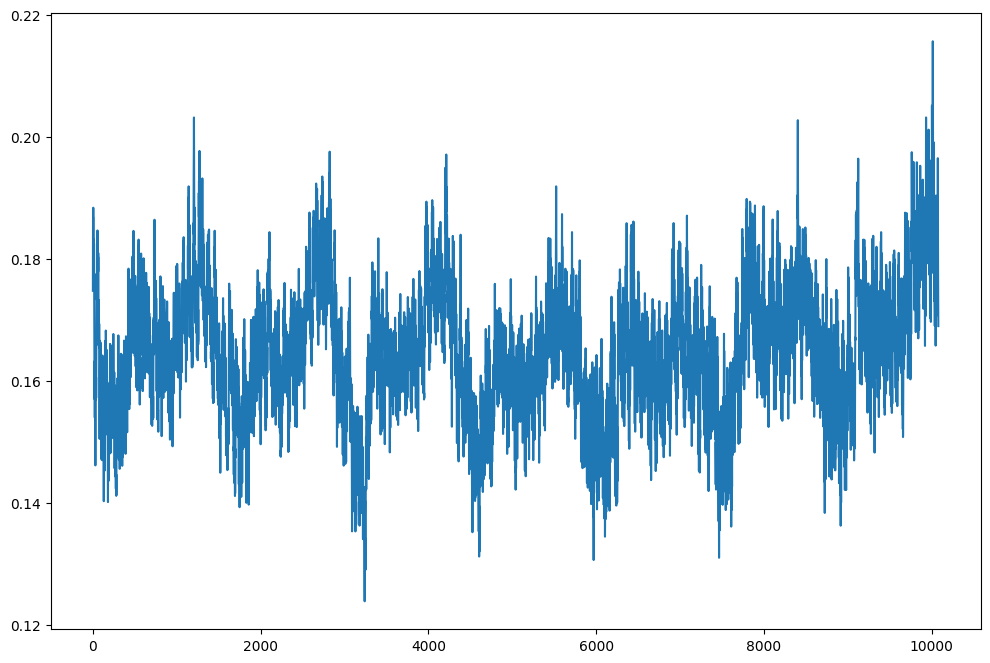

In [22]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')

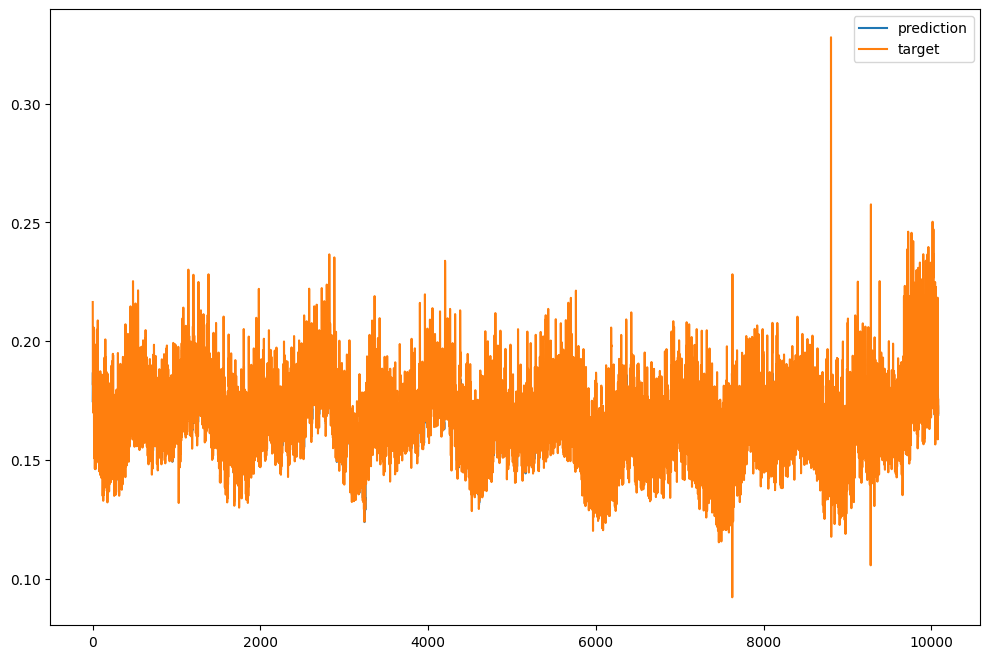

In [17]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [18]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 6.583741188049316 %


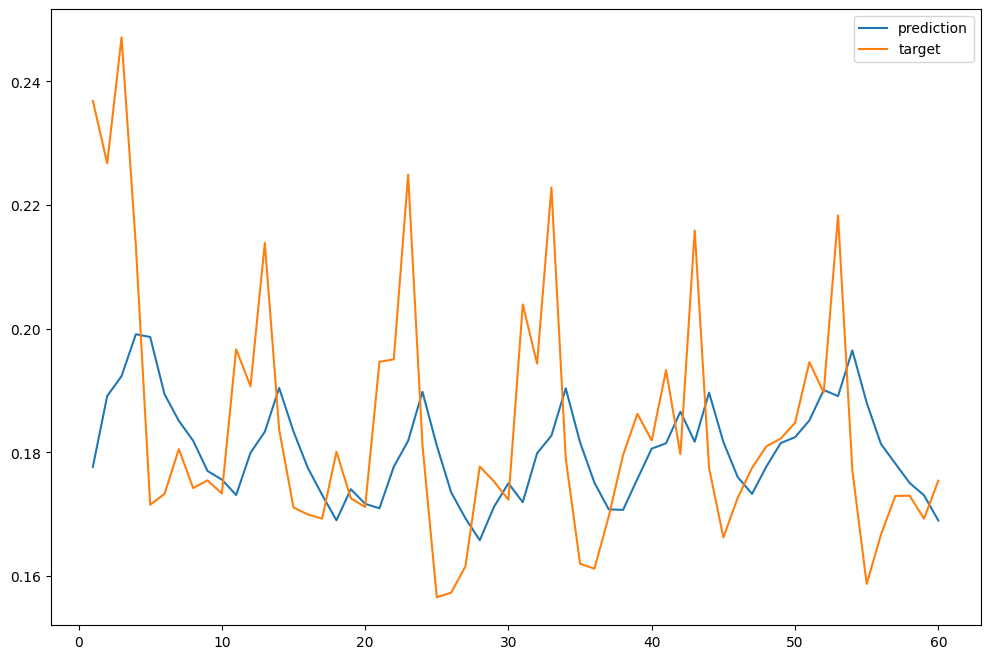

In [19]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [21]:
np.mean(time_list)

0.8998499868408082

<font color = blue><font size = 6> Conclusion </font></font><br>
DLienar online-learning과 NLinear online-learning에 비하면 매우 안좋은 SMAPE값이다 또한 한번 훈련하는데 0.6초가 걸렸는데 이는 속도가 무려 3배나 느리다는 것을 알려준다